<a href="https://colab.research.google.com/github/cristiangodoyangel/Analisis-Sismico-Chile-Data-Science/blob/main/Terremotos_en_Chile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import plotly.express as px

In [2]:
path = "/content/drive/MyDrive/0002 Python - Data Science/Datasets/seismic_data.csv"
df_1 = pd.read_csv(path)

In [3]:
df_1.head()

,Date(UTC),Latitude,Longitude,Depth,Magnitude
0,2025-05-26 03:50:27,-19.63,-69.49,97,5.6
1,2025-05-13 00:47:58,-51.25,-72.28,28,5.1
2,2025-05-05 09:46:48,-29.49,-71.84,48,5.0
3,2025-05-05 02:17:48,-31.89,-70.88,88,5.1
4,2025-05-02 15:23:49,-27.52,-72.48,30,5.8


In [4]:
df_1

,Date(UTC),Latitude,Longitude,Depth,Magnitude
0,2025-05-26 03:50:27,-19.63,-69.49,97,5.6
1,2025-05-13 00:47:58,-51.25,-72.28,28,5.1
2,2025-05-05 09:46:48,-29.49,-71.84,48,5.0
3,2025-05-05 02:17:48,-31.89,-70.88,88,5.1
4,2025-05-02 15:23:49,-27.52,-72.48,30,5.8
...,...,...,...,...,...
4013,2012-03-24 07:28:33,-33.05,-71.06,69,5.2
4014,2012-03-19 21:52:39,-25.00,-69.75,100,5.0
4015,2012-03-10 02:26:57,-19.74,-69.25,101,5.3
4016,2012-03-04 16:27:20,-21.60,-70.06,47,5.3


In [5]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4018 entries, 0 to 4017
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date(UTC)  4018 non-null   object 
 1   Latitude   4018 non-null   float64
 2   Longitude  4018 non-null   float64
 3   Depth      4018 non-null   int64  
 4   Magnitude  4018 non-null   float64
dtypes: float64(3), int64(1), object(1)
memory usage: 157.1+ KB


In [6]:
# Convertimos la fecha original a datetime
df_1['Fecha'] = pd.to_datetime(df_1['Date(UTC)'])

# Convertimos a horario chileno
df_1['Fecha_Chile'] = df_1['Fecha'].dt.tz_localize('UTC').dt.tz_convert('America/Santiago')

# Extraemos hora y mes
df_1['Hora'] = df_1['Fecha_Chile'].dt.hour
df_1['Mes'] = df_1['Fecha_Chile'].dt.month

# Diccionario de meses en español
meses = {
    1: "Enero", 2: "Febrero", 3: "Marzo", 4: "Abril",
    5: "Mayo", 6: "Junio", 7: "Julio", 8: "Agosto",
    9: "Septiembre", 10: "Octubre", 11: "Noviembre", 12: "Diciembre"
}
df_1['Mes_Nombre'] = df_1['Mes'].map(meses)
df_1.describe().T

,count,mean,min,25%,50%,75%,max,std
Latitude,4018.0,-27.837778,-62.35,-31.82,-29.595,-21.5125,-11.07,5.961963
Longitude,4018.0,-70.851127,-75.73,-71.59,-71.18,-70.03,-58.39,1.293387
Depth,4018.0,61.524639,2.0,36.0,50.0,86.0,624.0,38.27661
Magnitude,4018.0,4.428945,2.3,4.0,4.4,4.8,8.4,0.688666
Fecha,4018,2019-04-08 11:26:32.820308992,2012-03-03 11:01:47,2016-07-14 17:58:09,2019-06-01 21:22:07,2021-09-02 22:38:11,2025-05-26 03:50:27,NaN
Hora,4018.0,11.336237,0.0,5.0,11.0,17.0,23.0,6.905795
Mes,4018.0,6.574664,1.0,4.0,7.0,9.0,12.0,3.419187


In [8]:
import plotly.express as px

# Asegúrate de tener estos pasos antes
df_1['Fecha'] = pd.to_datetime(df_1['Date(UTC)'])
df_1['Fecha_Chile'] = df_1['Fecha'].dt.tz_localize('UTC').dt.tz_convert('America/Santiago')
df_1['Hora'] = df_1['Fecha_Chile'].dt.hour
df_1['Mes'] = df_1['Fecha_Chile'].dt.month

# Diccionario de meses
meses = {
    1: "Enero", 2: "Febrero", 3: "Marzo", 4: "Abril",
    5: "Mayo", 6: "Junio", 7: "Julio", 8: "Agosto",
    9: "Septiembre", 10: "Octubre", 11: "Noviembre", 12: "Diciembre"
}
df_1['Mes_Nombre'] = df_1['Mes'].map(meses)

# Aseguramos orden correcto de meses
orden_meses = list(meses.values())
df_1['Mes_Nombre'] = pd.Categorical(df_1['Mes_Nombre'], categories=orden_meses, ordered=True)

# Agrupamos por mes y hora
pivot_data = df_1.groupby(['Mes_Nombre', 'Hora']).size().reset_index(name='Cantidad')

fig = px.density_heatmap(
    pivot_data,
    x='Hora',
    y='Mes_Nombre',
    z='Cantidad',
    color_continuous_scale='Blues',
    title='🌡️ Intensidad de Sismos por Mes y Hora en Chile (2012–2025)',
    labels={'Hora': 'Hora del Día', 'Mes_Nombre': 'Mes', 'Cantidad': 'N° de Sismos'}
)

fig.update_layout(
    xaxis=dict(dtick=1, title_font_size=16, tickfont_size=14),
    yaxis=dict(title_font_size=16, tickfont_size=14),
    title_font_size=20,
    width=950,
    height=600
)

fig.show()





/tmp/ipython-input-8-758969471.py:22: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [13]:
import plotly.express as px

# Aseguramos que los meses estén en orden
orden_meses = ["Enero", "Febrero", "Marzo", "Abril",
               "Mayo", "Junio", "Julio", "Agosto",
               "Septiembre", "Octubre", "Noviembre", "Diciembre"]

# Aplicamos orden categórico
promedio_por_mes['Mes_Nombre'] = pd.Categorical(
    promedio_por_mes['Mes_Nombre'],
    categories=orden_meses,
    ordered=True
)

# Filtramos los primeros 4 meses
primer_cuatrimestre = promedio_por_mes[promedio_por_mes['Mes_Nombre'].isin(["Enero", "Febrero", "Marzo", "Abril"])]

# Creamos el gráfico
fig = px.bar(
    primer_cuatrimestre,
    x='Mes_Nombre',
    y='Cantidad',
    text='Cantidad',
    title='📊 Promedio de Sismos: Enero a Abril',
    labels={'Mes_Nombre': 'Mes', 'Cantidad': 'Promedio de Sismos'},
    color_discrete_sequence=['#00a8ca']
)

# Personalización
fig.update_traces(
    textposition='outside',
    textfont_size=20,
     width=0.4

)

fig.update_layout(
    title=dict(
        x=0.5,
        font=dict(size=32, family='Arial', color='black')
    ),
    yaxis_title=dict(
        text='Promedio de Sismos',
        font=dict(size=22, family='Arial', color='black')
    ),
    xaxis=dict(
        title=dict(
            text='Mes',
            font=dict(size=22, family='Arial', color='black')
        ),
        tickfont=dict(size=18)
    ),
    height=700,
    margin=dict(t=80, b=60, l=60, r=60),
    showlegend=False
)

fig.show()


/tmp/ipython-input-20-1475327738.py:32: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




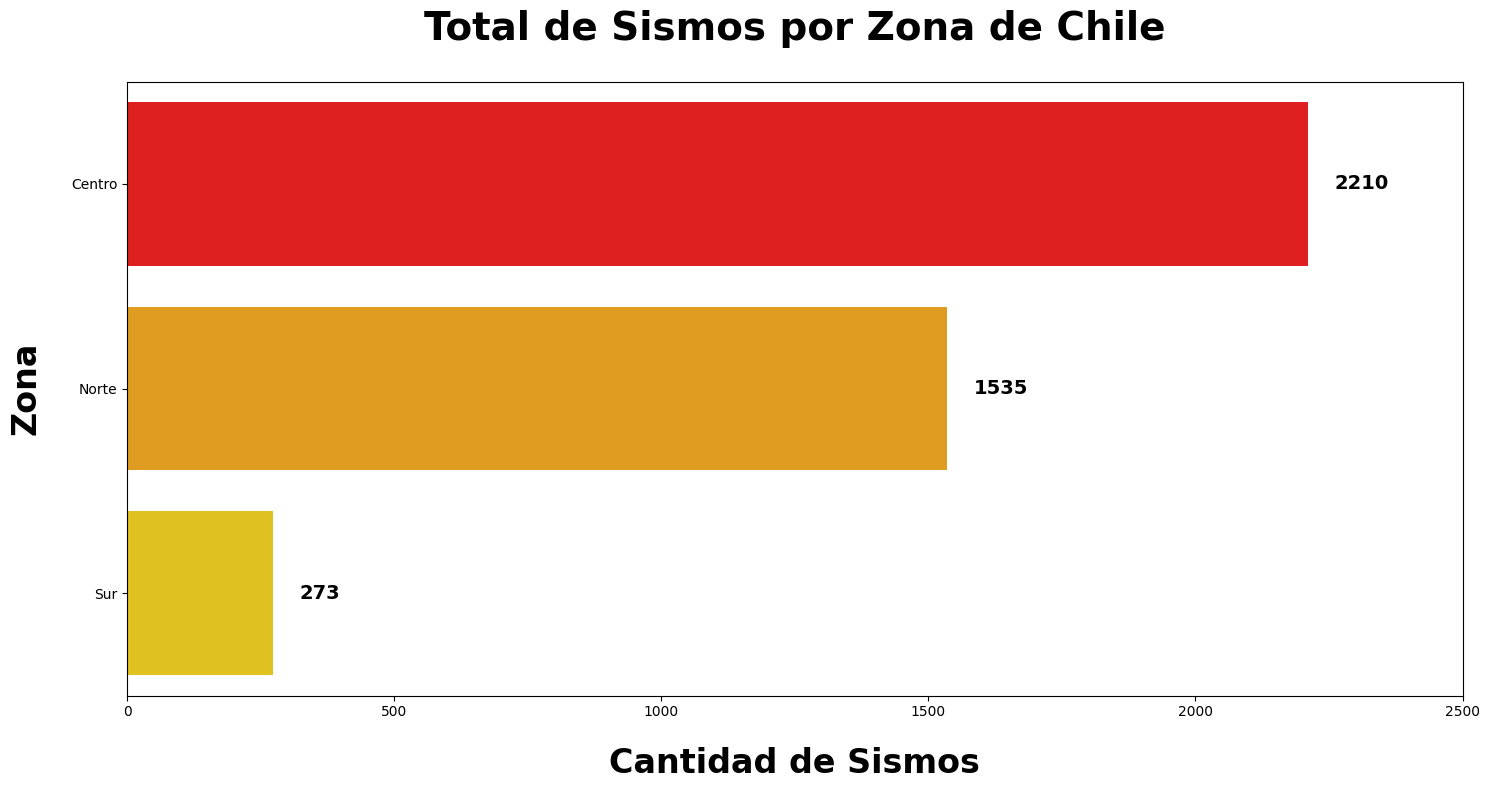

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar el archivo CSV
df = pd.read_csv("/content/drive/MyDrive/0002 Python - Data Science/Datasets/seismic_data.csv")

# Procesar fecha
df['Fecha'] = pd.to_datetime(df['Date(UTC)'])
df['Fecha_Chile'] = df['Fecha'].dt.tz_localize('UTC').dt.tz_convert('America/Santiago')

# Clasificación por zona (basado en latitud)
def clasificar_zona(lat):
    if lat >= -27:
        return 'Norte'
    elif lat >= -36:
        return 'Centro'
    else:
        return 'Sur'

df['Zona'] = df['Latitude'].apply(clasificar_zona)

# Agrupar y contar sismos por zona
sismos_por_zona = df['Zona'].value_counts().reset_index()
sismos_por_zona.columns = ['Zona', 'Cantidad']

# Colores para cada zona
colores = {'Norte': '#FFA500', 'Centro': '#FF0000', 'Sur': '#FFD700'}

# Crear gráfico
plt.figure(figsize=(15, 8))
sns.barplot(data=sismos_por_zona, x='Cantidad', y='Zona', palette=colores)

# Estética
plt.title('Total de Sismos por Zona de Chile', fontsize=28, fontweight='bold', pad=30)
plt.xlabel('Cantidad de Sismos', fontsize=24, fontweight='bold', labelpad=20)
plt.ylabel('Zona', fontsize=24, fontweight='bold', labelpad=20)

# Mostrar cantidad en las barras
for index, row in sismos_por_zona.iterrows():
    plt.text(row['Cantidad'] + 50, index, f"{row['Cantidad']}", va='center', fontsize=14, fontweight='bold')

plt.xlim(0, 2500)
plt.tight_layout()
plt.show()


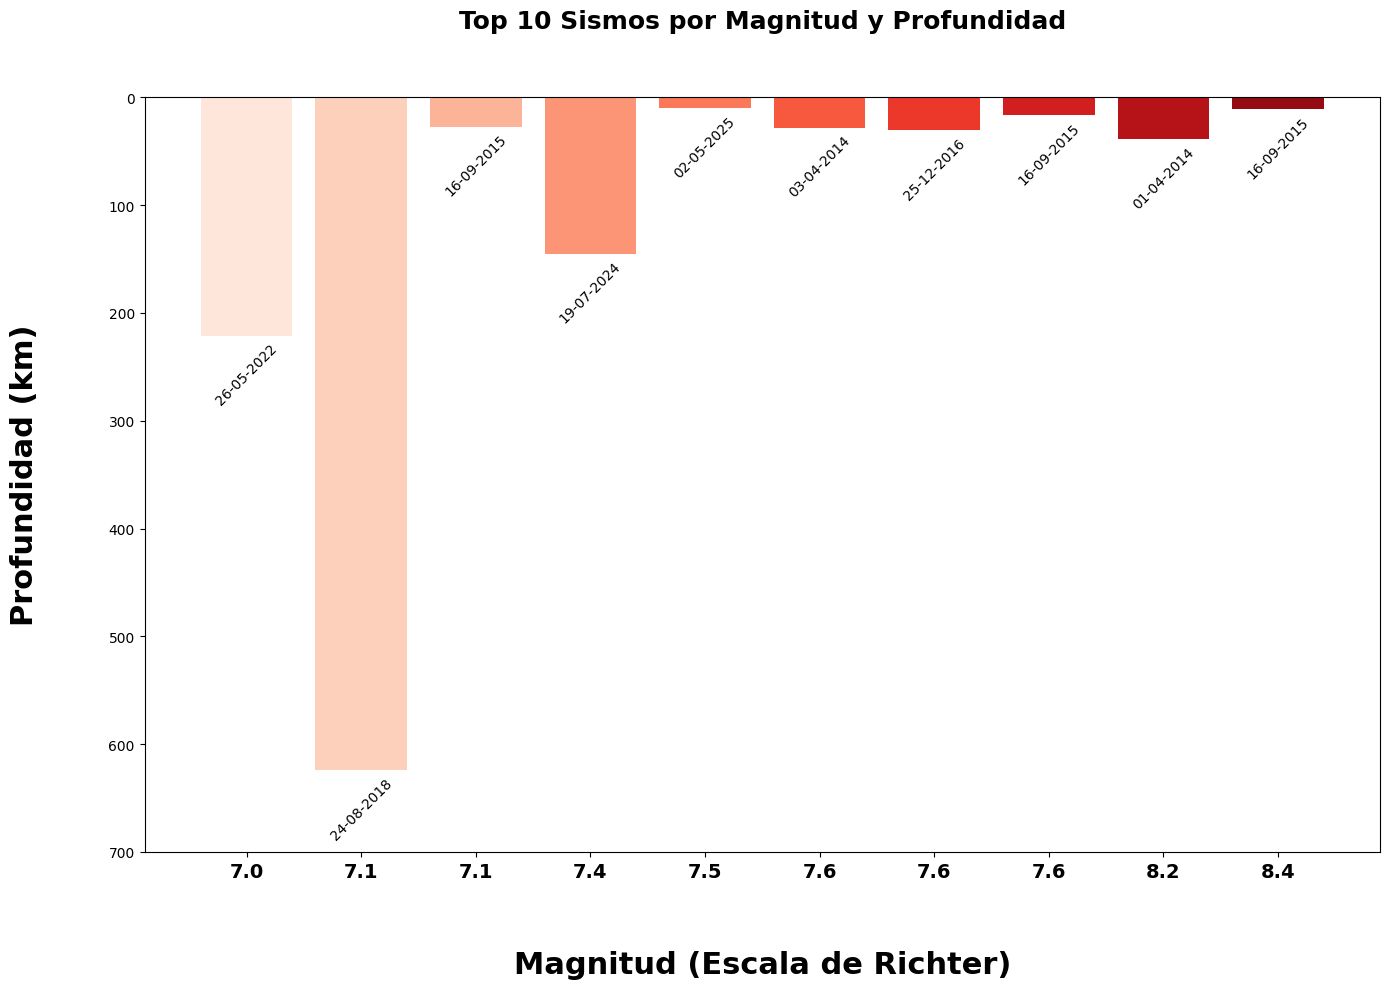

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar datos
df = pd.read_csv("/content/drive/MyDrive/0002 Python - Data Science/Datasets/seismic_data.csv")
df['Fecha'] = pd.to_datetime(df['Date(UTC)'])
df['Fecha_Chile'] = df['Fecha'].dt.tz_localize('UTC').dt.tz_convert('America/Santiago')

# Top 10 sismos por magnitud
# Ordenar por magnitud ascendente
top_10_sorted = top_10.sort_values(by='Magnitude', ascending=True).reset_index(drop=True)

# Crear gráfico
plt.figure(figsize=(14, 10))
colors = sns.color_palette("Reds", len(top_10_sorted))  # De rojo claro a rojo oscuro
bars = plt.bar(x=top_10_sorted.index, height=top_10_sorted['Depth'], color=colors)

# Invertir eje Y (profundidad hacia abajo)

plt.gca().invert_yaxis()
plt.ylim(700, 0)

# Etiquetas
plt.title("Top 10 Sismos por Magnitud y Profundidad", fontsize=18, fontweight='bold', pad=50)
plt.xlabel("Magnitud (Escala de Richter)", fontsize=22, fontweight='bold', labelpad=50)
plt.ylabel('Profundidad (km)', fontsize=22, fontweight='bold',labelpad=50)
plt.xticks(top_10.index, [f"{mag:.1f}" for mag in top_10['Magnitude']], fontsize=12)



    # Mostrar fechas debajo de cada barra
for i, row in top_10_sorted.iterrows():
    plt.text(i, row['Depth'] + 5, row['Fecha'].strftime('%d-%m-%Y'),
             ha='center', va='top', fontsize=10, rotation=45)

    # Etiquetas en eje X (magnitudes)
plt.xticks(ticks=top_10_sorted.index, labels=top_10_sorted['Magnitude'].round(1),fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()




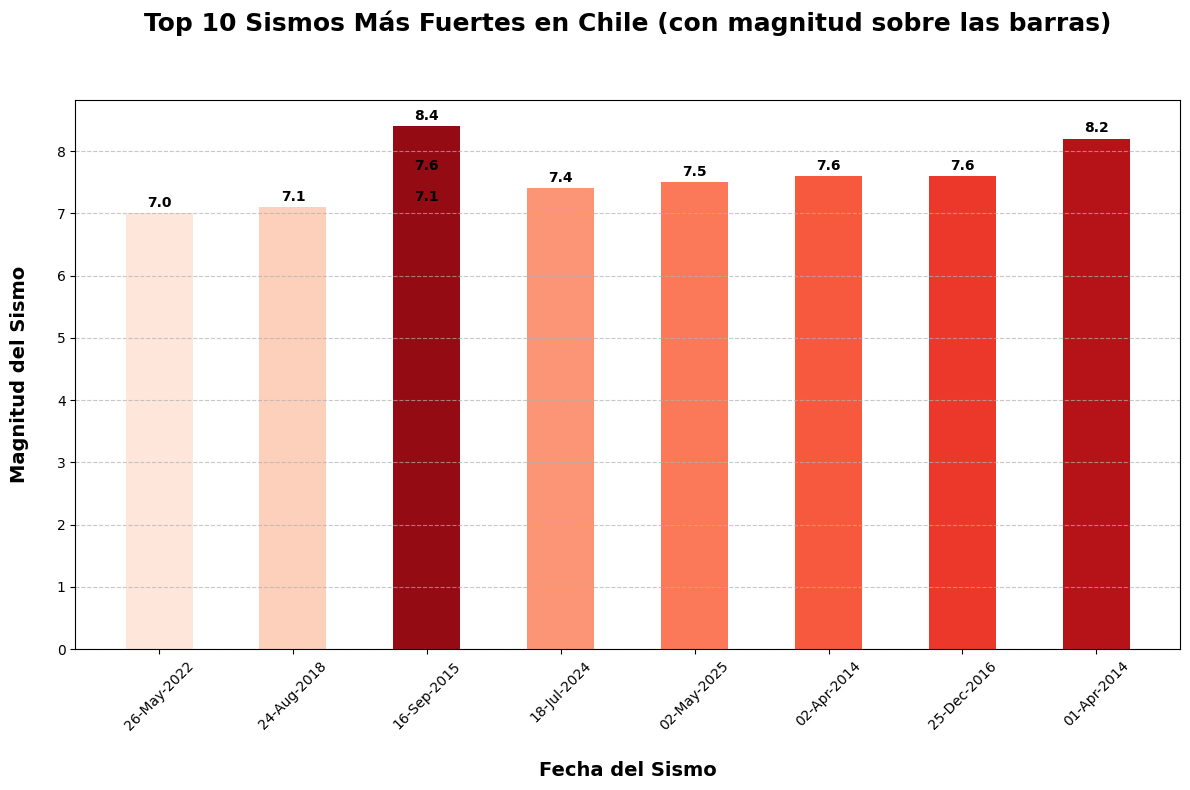

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Convertir fechas y ajustar zona horaria
df['Fecha'] = pd.to_datetime(df['Date(UTC)'], errors='coerce')
df['Fecha_Chile'] = df['Fecha'].dt.tz_localize('UTC').dt.tz_convert('America/Santiago')

# Filtrar top 10 sismos por magnitud
top_10 = df.nlargest(10, 'Magnitude')
top_10_sorted = top_10.sort_values(by='Magnitude').reset_index(drop=True)

# Etiquetas del eje X
x_labels = top_10_sorted['Fecha_Chile'].dt.strftime('%d-%b-%Y')

# Crear gráfico
plt.figure(figsize=(12, 8))
colors = sns.color_palette("Reds", len(top_10_sorted))
bars = plt.bar(
    x=x_labels,
    height=top_10_sorted['Magnitude'],
    color=colors,
    width=0.5
)

# Etiquetas de magnitud sobre cada barra
for bar, mag in zip(bars, top_10_sorted['Magnitude']):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.05,
        f"{mag:.1f}",
        ha='center',
        va='bottom',
        fontsize=10,
        fontweight='bold',
        color='black'
    )

# Estilo y etiquetas# Estilo de etiquetas y título
plt.ylabel('Magnitud del Sismo', fontsize=14, fontweight='bold', labelpad=20)
plt.xlabel('Fecha del Sismo', fontsize=14, fontweight='bold', labelpad=20)
plt.title('Top 10 Sismos Más Fuertes en Chile (con magnitud sobre las barras)', fontsize=18, fontweight='bold', pad=50)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)

# Mostrar gráfico
plt.tight_layout()
plt.show()

In [10]:
import pandas as pd
import plotly.express as px

# Asegúrate de tener el dataframe df_1 con la columna 'Fecha_Chile' y 'Mes_Nombre'
df_1['Mes'] = df_1['Fecha_Chile'].dt.month

# Diccionario de meses
meses = {
    1: "Enero", 2: "Febrero", 3: "Marzo", 4: "Abril",
    5: "Mayo", 6: "Junio", 7: "Julio", 8: "Agosto",
    9: "Septiembre", 10: "Octubre", 11: "Noviembre", 12: "Diciembre"
}
df_1['Mes_Nombre'] = df_1['Mes'].map(meses)

# Orden correcto de meses
orden_meses = list(meses.values())
df_1['Mes_Nombre'] = pd.Categorical(df_1['Mes_Nombre'], categories=orden_meses, ordered=True)

# Extraemos año
df_1['Año'] = df_1['Fecha_Chile'].dt.year

# Agrupamos por año y mes
conteo_mensual = df_1.groupby(['Año', 'Mes_Nombre']).size().reset_index(name='Cantidad')

# Promedio por mes
promedio_por_mes = conteo_mensual.groupby('Mes_Nombre')['Cantidad'].mean().reset_index()
promedio_por_mes['Cantidad'] = promedio_por_mes['Cantidad'].round(1)

# Clasificación en cuatrimestres
cuatrimestres = {
    "Enero": "T1", "Febrero": "T1", "Marzo": "T1", "Abril": "T1",
    "Mayo": "T2", "Junio": "T2", "Julio": "T2", "Agosto": "T2",
    "Septiembre": "T3", "Octubre": "T3", "Noviembre": "T3", "Diciembre": "T3"
}
promedio_por_mes['Grupo'] = promedio_por_mes['Mes_Nombre'].map(cuatrimestres)

# Color uniforme
promedio_por_mes['Color'] = '#00a8ca'

# Gráfico
fig = px.bar(
    promedio_por_mes,
    x='Mes_Nombre',
    y='Cantidad',
    text='Cantidad',
    color='Grupo',
    color_discrete_map={'T1': '#00a8ca', 'T2': '#00a8ca', 'T3': '#00a8ca'},
    title='📊 Promedio de Sismos por Mes (Agrupado en Cuatrimestres)',
    labels={'Cantidad': 'Promedio de Sismos', 'Mes_Nombre': 'Mes'}
)

fig.update_traces(
    textposition='outside',
    textfont_size=22
)

fig.update_layout(
    title=dict(
        text='📊 Promedio de Sismos por Mes (Agrupado en Cuatrimestres)',
        x=0.5,
        font=dict(size=40, family='Arial', color='black')
    ),
    yaxis_title=dict(
        text='Promedio de Sismos',
        font=dict(size=26, family='Arial', color='black')
    ),
    xaxis=dict(
        title=dict(
            text='Mes',
            font=dict(size=26, family='Arial', color='black')
        ),
        tickfont=dict(size=20)
    ),
    height=1200,
    margin=dict(t=100, b=80, l=80, r=80),
    showlegend=False
)

fig.show()


/tmp/ipython-input-10-919751417.py:23: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipython-input-10-919751417.py:26: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

